--


c:\Users\inaga\OneDrive\Documentos\GitHub\TopoMap\vamana\lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


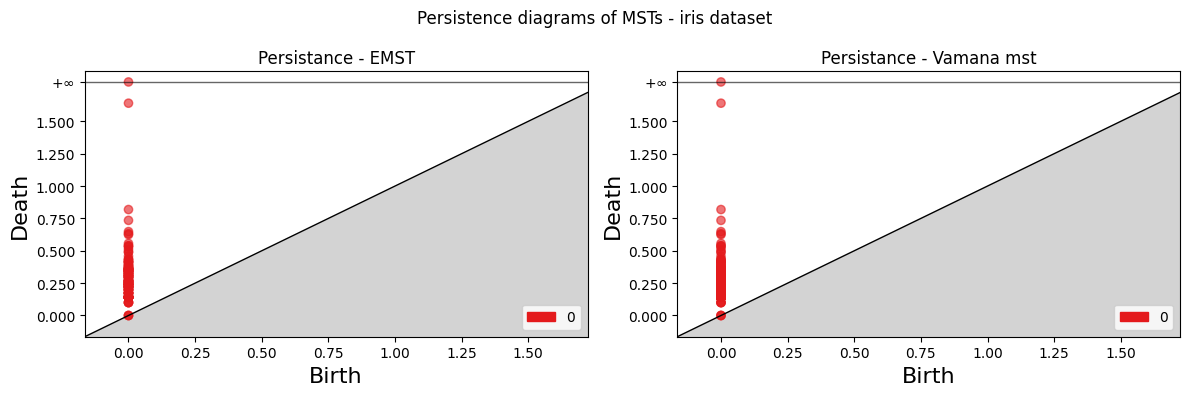

--


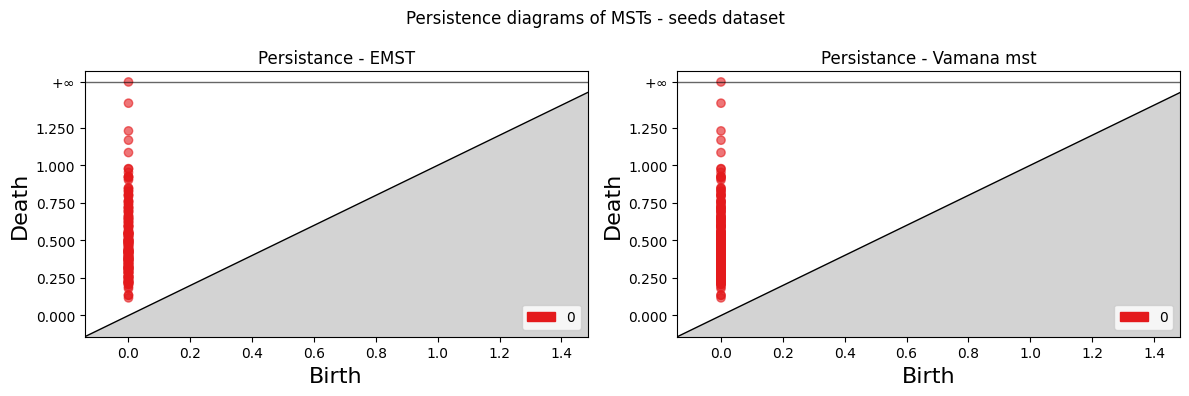

--


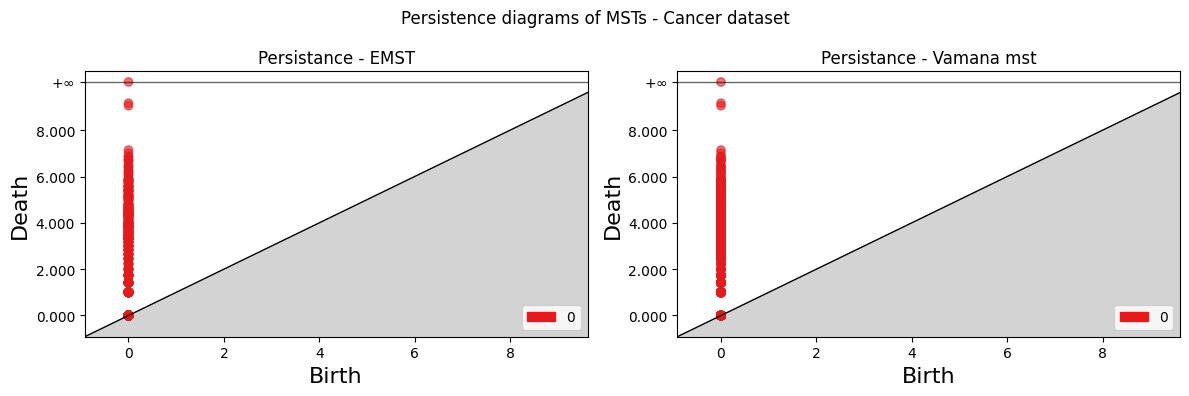

--


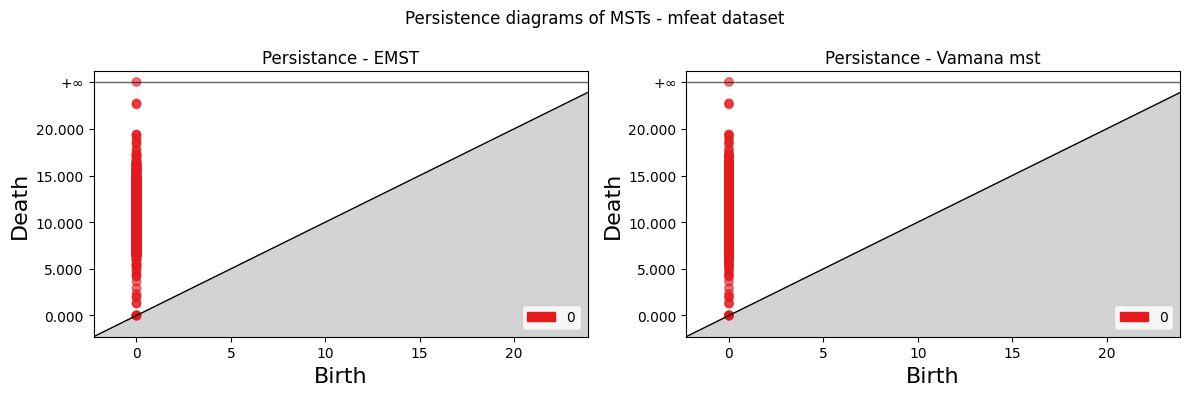

--


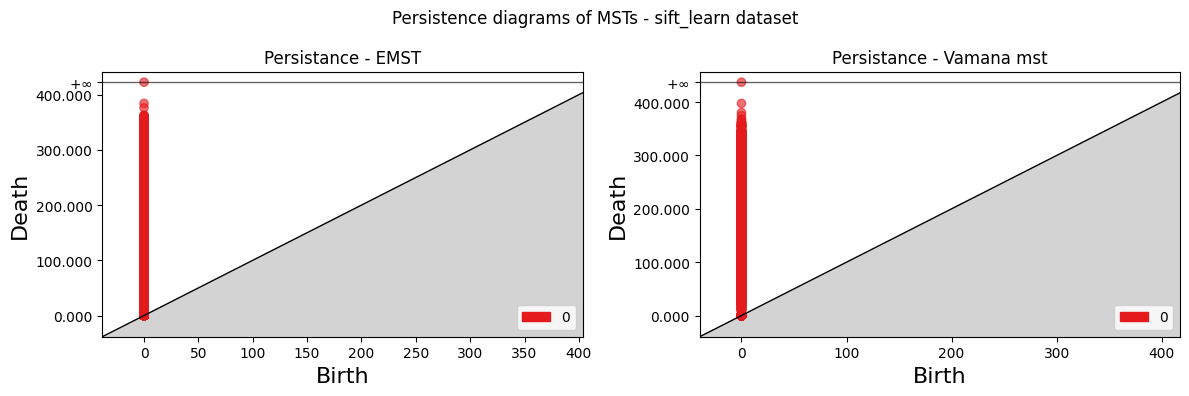

--


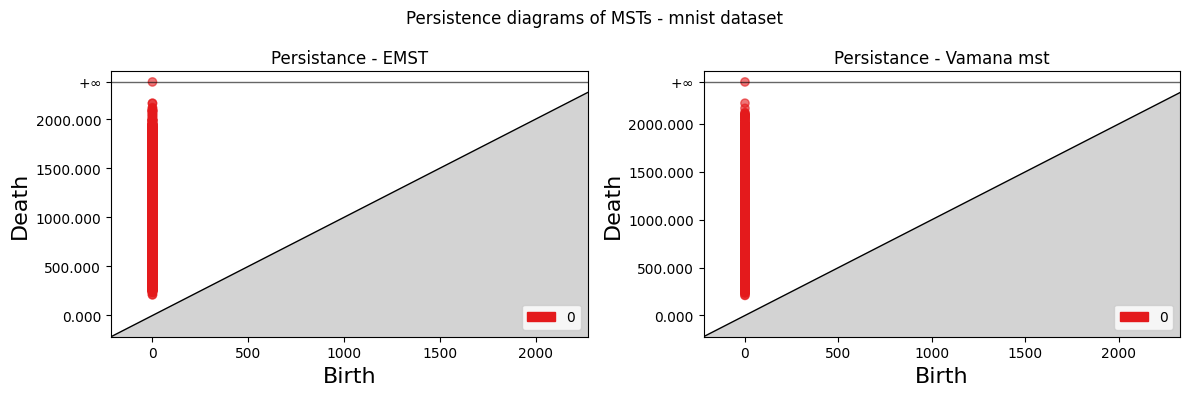

OSError: Cannot save file into a non-existent directory: '\out'

In [4]:
def run_all_ANN_tests():
    import pandas as pd
    from test_utils import MST_test_topology
    import os
    name_of_dir = "./data/fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                    (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                    (os.path.join(name_of_dir, x)).st_size)

    results = []
    datasets =[]

    for dataset in list_of_files:
        datasets.append(dataset)
        
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "VamanaIndexes/" + f'index_{name}_R64_L100_A1.2'
        result = MST_test_topology(data_path, index_path,name, save_msts= True)
        
        results.append(result)

        col_names = ["mlpack_building_time","ANN_building time","Bottleneck distance","number of equal_edges","percentual of equal edges","weight of equal edges","percentual weight of equal edges", "percentual total error"]

    df = pd.DataFrame(results, columns = col_names)
    
    
    df.index = datasets
    return df


df =run_all_ANN_tests()
df.to_csv('./out/mst_comparison.csv')






